# Exploring singlepoint

In [1]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
import json
import io
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import py3Dmol

os.chdir('../')

# For highlight colors
from matplotlib.colors import ColorConverter

from ipywidgets import interact,fixed,IntSlider


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Custom functions 
from my_utils.analysis import draw_generation,conf_viewer, sort_ga, natural_keys, atoi
from my_utils.classes import Generation

#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)


## Load the reference energies

In [2]:
def get_energy_dicts():

    path = Path(
        "/home/magstr/Documents/nitrogenase/niflheim_scripts/nitrogenase/reference_energies"
    )
    dict1_path = path / "gfn1_dict.json"
    dict2_path = path / "gfn2_dict.json"
    dict3_path = path / "dft_ams_dict.json"
    dict4_path = path / "dft_orca_dict.json"

    # Check for existing reference energy_dicts for speedup
    if (dict1_path.exists()) and (dict2_path.exists()) and (dict3_path.exists()) and (dict4_path.exists()):
        with open(dict1_path, "r", encoding="utf-8") as f:
            gfn1_dict = json.load(f)
        with open(dict2_path, "r", encoding="utf-8") as f:
            gfn2_dict = json.load(f)
        with open(dict3_path, "r", encoding="utf-8") as f:
            dft_ams_dict = json.load(f)
        with open(dict4_path, "r", encoding="utf-8") as f:
            dft_orca_dict = json.load(f)

        return gfn1_dict, gfn2_dict, dft_ams_dict, dft_orca_dict

    # Correction values
    g1_lut_corr = 10
    g1_cp_corr = -65
    g2_lut_corr = 0
    g2_cp_corr = -40

    gfn1_folders = (path / "gas_gfn1").rglob("*job.out")
    gfn2_folders = (path / "gas_gfn2").rglob("*job.out")

    gfn1_dict = {}
    for elem in gfn1_folders:
        gfn1_dict[elem.parent.name] = (
            HARTREE2KCAL * get_energies(paths=[elem], pattern="TOTAL ENERGY")[0]
        )
    gfn1_dict["delta_Cp"] = gfn1_dict["CrCp2+"] - gfn1_dict["CrCp2"] + g1_cp_corr
    gfn1_dict["delta_Lu"] = gfn1_dict["Lu"] - gfn1_dict["LuH+"] + g1_lut_corr

    gfn2_dict = {}
    for elem in gfn2_folders:
        gfn2_dict[elem.parent.name] = (
            HARTREE2KCAL * get_energies(paths=[elem], pattern="TOTAL ENERGY")[0]
        )
    gfn2_dict["delta_Cp"] = gfn2_dict["CrCp2+"] - gfn2_dict["CrCp2"] + g2_cp_corr
    gfn2_dict["delta_Lu"] = gfn2_dict["Lu"] - gfn2_dict["LuH+"] + g2_lut_corr

    dft_ams_folders = (path / "schrock_parts_ams").rglob("*dft.out")
    dft_ams_dict = {}
    for elem in dft_ams_folders:
        dft_ams_dict[elem.parent.name] = (
            HARTREE2KCAL * get_energies(paths=[elem], pattern="current energy")[0]
        )
    dft_ams_dict["delta_Cp"] = dft_ams_dict["CrCp2+"] - dft_ams_dict["CrCp2"]
    dft_ams_dict["delta_Lu"] = dft_ams_dict["Lu"] - dft_ams_dict["LuH+"]

    dft_ams_folders = (path / "parts_orca").rglob("*orca.out")
    dft_ams_dict = {}
    for elem in dft_ams_folders:
        dft_ams_dict[elem.parent.name] = (
                HARTREE2KCAL * get_energies(paths=[elem], pattern="FINAL SINGLE POINT")[0]
        )
    dft_ams_dict["delta_Cp"] = dft_ams_dict["CrCp2+"] - dft_ams_dict["CrCp2"]
    dft_ams_dict["delta_Lu"] = dft_ams_dict["Lu"] - dft_ams_dict["LuH+"]

    with open(dict1_path, "w") as fp:
        json.dump(gfn1_dict, fp)
    with open(dict2_path, "w") as fp:
        json.dump(gfn2_dict, fp)
    with open(dict3_path, "w") as fp:
        json.dump(dft_ams_dict, fp)
    with open(dict4_path, "w") as fp:
        json.dump(dft_orca_dict, fp)

    return gfn1_dict, gfn2_dict, dft_ams_dict, dft_ams_dict

In [3]:
(
        reactions_gfn1_corrected,
        reactions_gfn2_corrected,
        reactions_dft_ams_tzp,
        reactions_dft_orca_tzp,
    ) = get_energy_dicts()

In [4]:
reactions_dft_orca_tzp

{'N2': -68745.86604206839,
 'LuH+': -205372.4092126641,
 'Lu': -205110.45920451736,
 'H2': -731.7751548361912,
 'CrCp2+': -1150967.7260743862,
 'NH3': -35493.542519196264,
 'CrCp2': -1151066.3300395126,
 'delta_Cp': 98.60396512644365,
 'delta_Lu': 261.95000814672676}

In [5]:
eV = 27.2114
kcal = 627.51

# Singlepoint from GA analysis (before ind was saved)

In [6]:
def extract_energyxtb(logfile=None):
    """
    Extracts xtb energies from xtb logfile using regex matching.

    Args:
        logfile (str): Specifies logfile to pull energy from

    Returns:
        energy (List[float]): List of floats containing the energy in each step
    """

    re_energy = re.compile("energy: (-\\d+\\.\\d+)")
    energy = []
    with logfile.open() as f:
        for line in f:
            if "energy" in line:
                energy.append(float(re_energy.search(line).groups()[0]))
    return energy

In [7]:
def read_properties_sp(logfile):
    """
    Read Singlepoint Energy
    """
    with logfile.open() as f:
    
        for line in f:
            if "FINAL SINGLE POINT ENERGY" in line:
                scf_energy = float(line.split()[4])
                break
            else:
                scf_energy = None

    return scf_energy

In [8]:
logfile = Path('/home/magstr/dft_data/debug/')

In [9]:
f = sorted(logfile.glob('*'))

In [10]:
f

[PosixPath('/home/magstr/dft_data/debug/14_18_Mo_N2'),
 PosixPath('/home/magstr/dft_data/debug/14_18_Mo_NH3'),
 PosixPath('/home/magstr/dft_data/debug/19_32_Mo_N2'),
 PosixPath('/home/magstr/dft_data/debug/19_32_Mo_NH3'),
 PosixPath('/home/magstr/dft_data/debug/28_28_Mo_N2'),
 PosixPath('/home/magstr/dft_data/debug/28_28_Mo_NH3'),
 PosixPath('/home/magstr/dft_data/debug/2_3_Mo_N2'),
 PosixPath('/home/magstr/dft_data/debug/2_3_Mo_NH3'),
 PosixPath('/home/magstr/dft_data/debug/42_26_Mo_N2'),
 PosixPath('/home/magstr/dft_data/debug/42_26_Mo_NH3'),
 PosixPath('/home/magstr/dft_data/debug/47_21_Mo_N2'),
 PosixPath('/home/magstr/dft_data/debug/47_21_Mo_NH3'),
 PosixPath('/home/magstr/dft_data/debug/47_39_Mo_N2'),
 PosixPath('/home/magstr/dft_data/debug/47_39_Mo_NH3'),
 PosixPath('/home/magstr/dft_data/debug/4_20_Mo_N2'),
 PosixPath('/home/magstr/dft_data/debug/4_20_Mo_NH3'),
 PosixPath('/home/magstr/dft_data/debug/4_34_Mo_N2'),
 PosixPath('/home/magstr/dft_data/debug/4_34_Mo_NH3'),
 PosixPat

In [11]:
a = f[::2]

In [12]:
for elem in a:
    a = sorted(logfile.glob(f'{elem.name[0:4]}*'))
    
    p1 = sorted(a[0].glob('*orca.out'))
    p2 = sorted(a[1].glob('*orca.out'))
    print(p1,p2)
    
    N2 = read_properties_sp(p1[0])
    NH3 = read_properties_sp(p2[0])
    print(N2,NH3)
    
    delta = ((N2*kcal+reactions_dft_orca_tzp['NH3'])-(NH3*kcal+reactions_dft_orca_tzp['N2']))
    print(delta)

[PosixPath('/home/magstr/dft_data/debug/14_18_Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/debug/14_18_Mo_NH3/orca.out')]
-7016.359843464012 -6963.405714742332
23.07820873055607
[PosixPath('/home/magstr/dft_data/debug/19_32_Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/debug/19_32_Mo_NH3/orca.out')]
-6443.313093725846 -6390.341023486578
11.81972702872008
[PosixPath('/home/magstr/dft_data/debug/28_28_Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/debug/28_28_Mo_NH3/orca.out')]
-6561.18891849947 -6508.252362592815
34.1053258869797
[PosixPath('/home/magstr/dft_data/debug/2_3_Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/debug/2_3_Mo_NH3/orca.out')]
-6218.387689385174 -6165.423881765083
17.004603188484907
[PosixPath('/home/magstr/dft_data/debug/42_26_Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/debug/42_26_Mo_NH3/orca.out')]
-6210.741189121704 -6158.147213690062
249.07799976179376
[PosixPath('/home/magstr/dft_data/debug/47_21_Mo_N2/orca.out')] [PosixPath('/ho

In [13]:
orca_files[0].parent

NameError: name 'orca_files' is not defined

In [14]:
read_properties_sp(logfile)

IsADirectoryError: [Errno 21] Is a directory: '/home/magstr/dft_data/debug'

In [15]:
files = sorted(logfile.rglob('*.xyz'))

In [16]:
extract_energyxtb(files[0])

[-199.090144399448]

In [17]:
delta = ((N2*kcal+reactions_dft_tzp['NH3'])-(NH3*kcal+reactions_dft_tzp['N2_en']))

NameError: name 'reactions_dft_tzp' is not defined

NameError: name 'df_total' is not defined

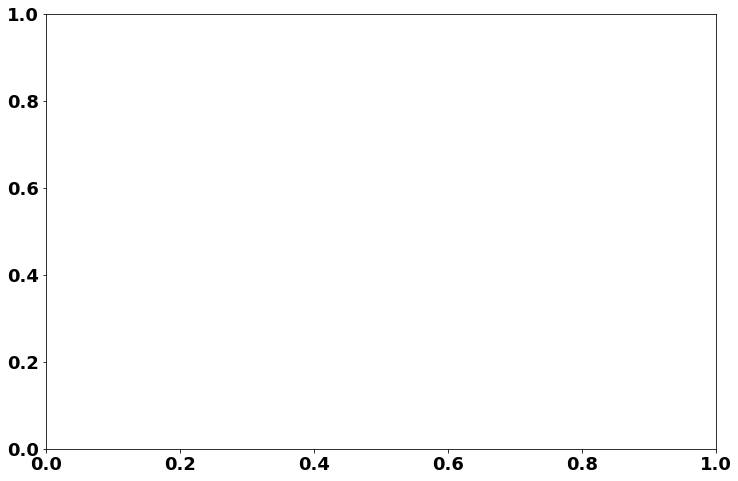

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
df_total[['score','DFT']].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *')
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()
fig.savefig('singlepoints.png')

# Singlepoint from GA analysis

In [19]:
logfile = [Path('/home/magstr/dft_data/prod_new12_0')]

In [60]:
f = sorted(logfile.glob('*'))

AttributeError: 'list' object has no attribute 'glob'

In [50]:
f

[PosixPath('/home/magstr/dft_data/prod_new12_0/13_20'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/14_24'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/15_24'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/15_6'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/16_11'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/16_29'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/18_22'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/26_35'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/31_6'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/37_12'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/37_15'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/47_36'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/8_23'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/9_25'),
 PosixPath('/home/magstr/dft_data/prod_new12_0/9_47')]

In [29]:
# Crucial code for unpickling objects with old module names
class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        renamed_module = module
        if module == "my_utils.my_utils":
            renamed_module = "my_utils.classes"

        return super(RenameUnpickler, self).find_class(renamed_module, name)


def renamed_load(file_obj):
    return RenameUnpickler(file_obj).load()


def renamed_loads(pickled_bytes):
    file_obj = io.BytesIO(pickled_bytes)
    return renamed_load(file_obj)

In [30]:
inds = []
deltas = []
for elem in f:
    p_nh3 = elem / 'Mo_NH3'
    p_n2 = elem / 'Mo_N2'
    
    p1 = sorted(p_n2.glob('*orca.out'))
    p2 = sorted(p_nh3.glob('*orca.out'))Jul
    print(p1,p2)
    
    N2 = read_properties_sp(p1[0])
    NH3 = read_properties_sp(p2[0])
    if not (N2 or NH3):
        delta = None
    else:
        delta = ((N2*kcal+reactions_dft_orca_tzp['NH3'])-(NH3*kcal+reactions_dft_orca_tzp['N2']))
        #print(delta)
    deltas.append(delta)
    # Get the ind object 
    ind = sorted(elem.rglob('*ind.pkl'))[0]
    
    with open(ind, "rb") as f:
        ind = renamed_load(f)
        inds.append(ind)
        
    
gen = Generation(molecules=inds)

SyntaxError: invalid syntax (454992533.py, line 8)

In [31]:
inds[1].original_mol

IndexError: list index out of range

In [32]:
df = gen.gen2pd()
df['DFT'] = deltas
df['score'] = df['score'].apply(lambda x: round(x, 1))
df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
df.sort_values(by=['score'], inplace=True)
df

NameError: name 'gen' is not defined

In [33]:
df.iloc[1]

IndexError: single positional indexer is out-of-bounds

In [34]:
df.iloc[1]['rdkit_mol']

IndexError: single positional indexer is out-of-bounds

TypeError: no numeric data to plot

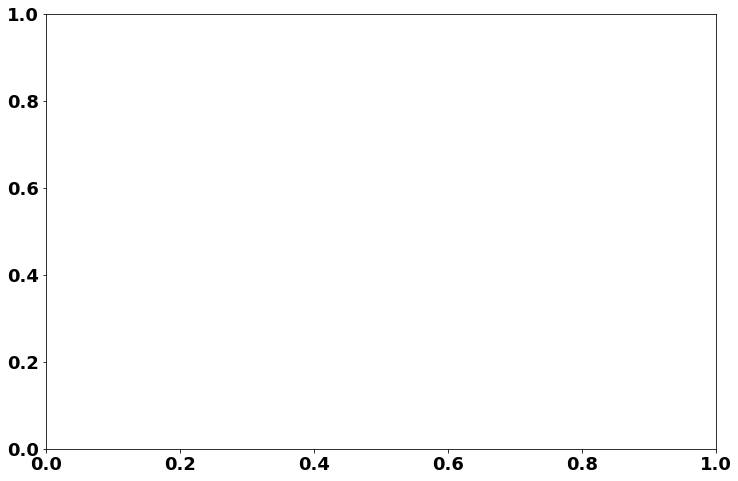

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
df[['score','DFT']].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *', xlabel='Molecule No.')
#ax.set_xticks([f'Molecule {x}' for x in range(5)])
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()
fig.savefig('singlepoints.svg')

### Correlation plot

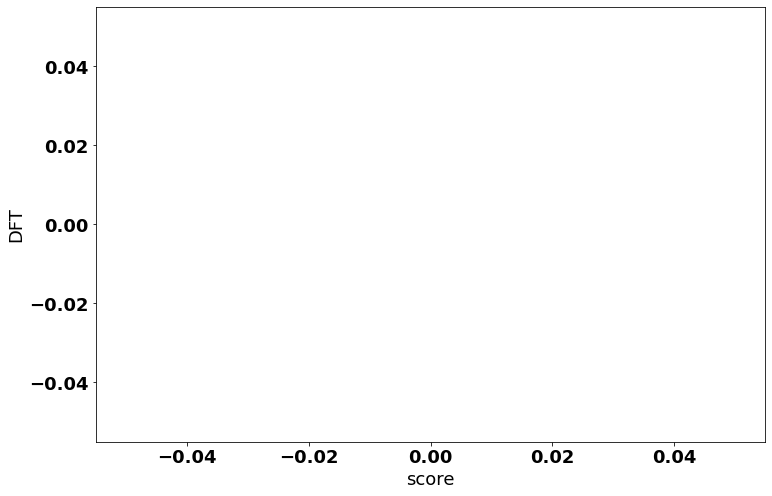

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x="score", y="DFT",ci=68,truncate=False,data=df, ax=ax);

# Singlepoint from GA analysis multiple

In [55]:
logfiles = [Path('/home/magstr/dft_data/prod_new15_large_0')]

In [56]:
#N2 = read_properties_sp(p1[0])
#NH3 = read_properties_sp(p2[0])

In [57]:
if not (N2 or NH3):
    print('lol')

lol


In [58]:
for elem in logfiles:
    print(sorted(elem.glob('*')))

[PosixPath('/home/magstr/dft_data/prod_new15_large_0/10_22'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/10_25'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/13_27'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/15_14'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/15_36'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/18_7'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/19_26'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/20_31'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/20_34'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/21_39'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/23_8'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/28_12'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/28_31'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/29_27'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/30_31'), PosixPath('/home/magstr/dft_data/prod_new15_large_0/32_18'), PosixPath('/home/magstr/d

In [61]:
total_df = pd.DataFrame(columns=['score', 'energy', 'sa_score', 'rdkit_mol', 'DFT'])
inds = []
deltas = []
for file in logfiles:
    f = sorted(file.glob('*'))
    for elem in f:
        print(elem)
        p_nh3 = elem / 'Mo_NH3'
        p_n2 = elem / 'Mo_N2'

        p1 = sorted(p_n2.glob('*orca.out'))
        p2 = sorted(p_nh3.glob('*orca.out'))
        print(p1,p2)
        
        N2 = read_properties_sp(p1[0])
        NH3 = read_properties_sp(p2[0])
        if not (N2 and NH3):
            delta = None
        else:
            delta = ((N2*kcal+reactions_dft_orca_tzp['NH3'])-(NH3*kcal+reactions_dft_orca_tzp['N2']))
            #print(delta)
        deltas.append(delta)

        # Get the ind object 
        ind = sorted(elem.rglob('*ind.pkl'))[0]

        with open(ind, "rb") as f:
            ind = renamed_load(f)
            inds.append(ind)

    gen = Generation(molecules=inds)
    df = gen.gen2pd()
    df['DFT'] = deltas
    df['score'] = df['score'].apply(lambda x: round(x, 1))
    df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
    df.sort_values(by=['score'], inplace=True)
    total_df = pd.concat([total_df, df])
    df

/home/magstr/dft_data/prod_new15_large_0/10_22
[PosixPath('/home/magstr/dft_data/prod_new15_large_0/10_22/Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/prod_new15_large_0/10_22/Mo_NH3/orca.out')]
/home/magstr/dft_data/prod_new15_large_0/10_25
[PosixPath('/home/magstr/dft_data/prod_new15_large_0/10_25/Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/prod_new15_large_0/10_25/Mo_NH3/orca.out')]
/home/magstr/dft_data/prod_new15_large_0/13_27
[PosixPath('/home/magstr/dft_data/prod_new15_large_0/13_27/Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/prod_new15_large_0/13_27/Mo_NH3/orca.out')]
/home/magstr/dft_data/prod_new15_large_0/15_14
[PosixPath('/home/magstr/dft_data/prod_new15_large_0/15_14/Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/prod_new15_large_0/15_14/Mo_NH3/orca.out')]
/home/magstr/dft_data/prod_new15_large_0/15_36
[PosixPath('/home/magstr/dft_data/prod_new15_large_0/15_36/Mo_N2/orca.out')] [PosixPath('/home/magstr/dft_data/prod_new15_large_0/15_36/Mo_NH3/or

In [62]:
df = total_df
#df.sort_values(by=['score'], inplace=True)

In [63]:
df

,score,energy,sa_score,rdkit_mol,DFT
"(37, 49)",-128.5,-129.750386,0.990219,<rdkit.Chem.rdchem.Mol object at 0x7f50f5369970>,201.1
"(20, 31)",-72.4,-72.413743,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f54117b0>,-14.3
"(37, 36)",-65.2,-65.238807,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f5402cb0>,-27.2
"(9, 35)",-62.1,-62.113881,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f53696f0>,-24.1
"(13, 27)",-62.1,-62.081733,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f53ee930>,-27.8
"(45, 2)",-61.6,-61.576054,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f5369c30>,-44.9
"(20, 34)",-61.1,-61.069443,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f54094b0>,-25.6
"(45, 48)",-60.3,-60.316929,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f5369d30>,-31.1
"(19, 26)",-60.3,-60.333260,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f53ee8b0>,-28.3
"(41, 7)",-60.0,-60.013226,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f5369ab0>,-22.9


In [64]:
list_of_moles = df['rdkit_mol'].tolist()

In [65]:
list_of_moles

In [66]:
df

,score,energy,sa_score,rdkit_mol,DFT
"(37, 49)",-128.5,-129.750386,0.990219,<rdkit.Chem.rdchem.Mol object at 0x7f50f5369970>,201.1
"(20, 31)",-72.4,-72.413743,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f54117b0>,-14.3
"(37, 36)",-65.2,-65.238807,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f5402cb0>,-27.2
"(9, 35)",-62.1,-62.113881,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f53696f0>,-24.1
"(13, 27)",-62.1,-62.081733,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f53ee930>,-27.8
"(45, 2)",-61.6,-61.576054,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f5369c30>,-44.9
"(20, 34)",-61.1,-61.069443,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f54094b0>,-25.6
"(45, 48)",-60.3,-60.316929,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f5369d30>,-31.1
"(19, 26)",-60.3,-60.333260,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f53ee8b0>,-28.3
"(41, 7)",-60.0,-60.013226,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f50f5369ab0>,-22.9


In [67]:
#Chem.Draw.MolsToGridImage(list_of_moles)

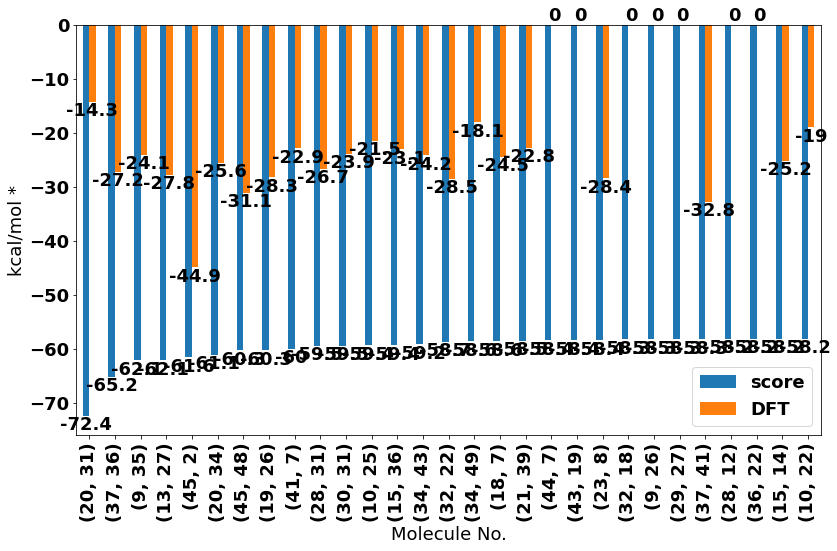

In [70]:
fig, ax = plt.subplots(figsize=(12, 8))
df[['score','DFT']].iloc[1:].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *', xlabel='Molecule No.')
#ax.set_xticks([f'Molecule {x}' for x in range(5)])
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()
#fig.savefig('singlepoints.svg')

# Correlation plot

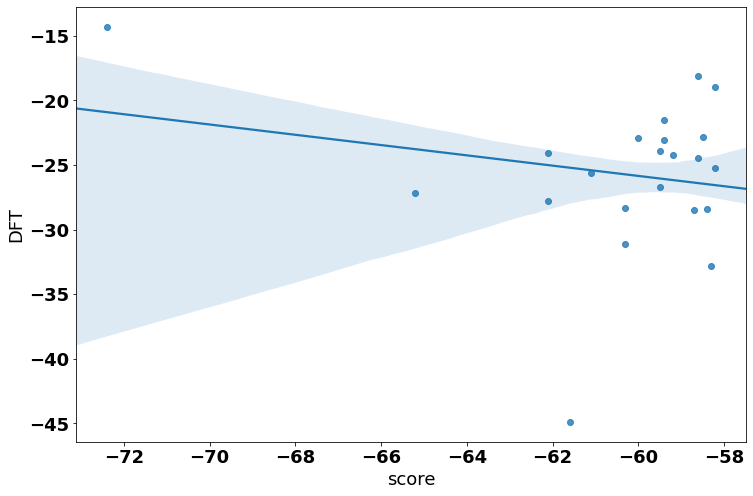

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x="score", y="DFT",ci=68,truncate=False,data=df.iloc[1:], ax=ax);